## Exploratory Data Analysis and Preparation
This notebook showcases the pipeline for the preparation of our datasets from the different modalities used for our research problem.


Import necessary libraries

In [1]:
import os, warnings
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

import umap

/anvil/projects/x-cis250634/team5/envs/flood_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Merge datasets from all modalities

In [2]:
base_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(base_dir, 'data')

file_names = [
    'dem_features.csv',
    'combined_nlcd_features.csv',
    'precipitation.csv',
    'sentinel1_combined_features.csv',
    'USGS_HWM_Height.csv',
    'soil_moisture.csv',
    'Weather_Data.csv'
]

# Read and merge all files on 'ID' with custom suffixes
merged_df = pd.read_csv(os.path.join(data_dir, file_names[0]))

if 'file_id' in merged_df.columns:
    merged_df = merged_df.rename(columns={'file_id': 'ID'})
unnamed_cols = [col for col in merged_df.columns if col.startswith('Unnamed')]
merged_df = merged_df.drop(columns=unnamed_cols)

unique_columns = ['ID', 'peak_date', 'S1_Date']

for i, file in enumerate(file_names[1:], 1):
    df = pd.read_csv(os.path.join(data_dir, file))
    unnamed_cols = [col for col in df.columns if col.startswith('Unnamed')]
    df = df.drop(columns=unnamed_cols)
    cols_to_keep = ['ID'] + [col for col in df.columns
                            if col not in merged_df.columns or col not in unique_columns]
    df_filtered = df[cols_to_keep]
    merged_df = pd.merge(merged_df, df_filtered, on='ID')
combined_features = merged_df.drop(columns={'year','projection', 'nlcd_year'}, errors='ignore')
print("all data merged successfully")

all data merged successfully


Date Time Cyclical Transformation

In [3]:
# Convert to datetime and extract temporal features
combined_features['peak_date'] = pd.to_datetime(combined_features['peak_date'], format='%m/%d/%Y %I:%M:%S %p')
# Set ID as index to preserve it
combined_features = combined_features.set_index('ID')

# Extract and encode temporal features in one go
temporal_features = {
    'month': (combined_features['peak_date'].dt.month, 12),
    'day': (combined_features['peak_date'].dt.day, 31),
    'hour': (combined_features['peak_date'].dt.hour, 24)
}
# Create cyclical features and add year
combined_features['year'] = combined_features['peak_date'].dt.year
for feature, (values, period) in temporal_features.items():
    combined_features[f'{feature}_sin'] = np.sin(2 * np.pi * values / period)

combined_features = combined_features.drop(columns=['peak_date', 'S1_Date']).select_dtypes(exclude=['datetime64'])
print("Cyclical features created successfully")

Cyclical features created successfully


Handling Missing Data with KNN Imputation

In [4]:
imputer = KNNImputer(n_neighbors=3)
df_imputed_array = imputer.fit_transform(combined_features)

# Convert back to DataFrame to preserve column names
df_imputed = pd.DataFrame(df_imputed_array,
                         columns=combined_features.columns,
                         index=combined_features.index)
df_imputed['year'] = df_imputed['year'].astype('Int64')
print("all missing data handled successfully")

all missing data handled successfully


Export the combined features to a file

In [5]:
# df_imputed.to_csv(os.path.join('../data/combined_features.csv'))
df_imputed.to_csv(os.path.join(data_dir, 'combined_features.csv'))
print("Combined features saved successfully")


Combined features saved successfully


Show 15 random samples of the datasets

In [6]:
df_imputed.sample(10)

,dem_min,dem_max,dem_mean,dem_iqr,total_area_km2,pct_area_1,pct_area_2,area_km_1,area_km_2,cai_1,...,feelslike_c,windchill_c,heatindex_c,chance_of_rain,chance_of_snow,vis_km,year,month_sin,day_sin,hour_sin
ID,,,,,,,,,,,,,,,,,,,,,
3582,67.080000,100.999950,83.408714,9.235327,9.1809,4.528968,1.999804,0.4158,0.1836,0.000000,...,25.7,23.8,25.7,0.0,0.0,10.0,2017,-0.866025,-0.201299,-0.965926
3730,68.426605,117.238230,88.208960,17.337364,9.1809,6.107244,0.745025,0.5607,0.0684,12.690355,...,24.9,22.7,24.9,0.0,0.0,10.0,2017,-0.866025,-0.201299,-0.965926
5335,-0.525875,5.380000,0.065067,1.003270,9.1809,15.714146,18.331536,1.4427,1.6830,8.490566,...,35.6,29.2,35.6,100.0,0.0,5.0,2017,-1.000000,0.897805,0.707107
3214,-0.350000,11.060323,4.366738,1.989084,9.1809,49.553965,46.279776,4.5495,4.2489,16.666667,...,27.2,24.5,27.2,100.0,0.0,5.0,2017,-0.866025,-0.394356,-0.965926
6663,52.620327,115.251990,71.769394,31.109202,9.1809,3.764337,0.137241,0.3456,0.0126,0.000000,...,13.9,13.9,14.8,0.0,0.0,10.0,2018,-0.866025,-0.485302,-0.866025
3993,47.300000,69.087250,59.509468,2.988719,9.1809,23.821194,28.820704,2.1870,2.6460,12.000000,...,24.9,22.7,24.9,0.0,0.0,10.0,2017,-0.866025,-0.201299,-0.965926
3856,53.435448,81.271630,65.829900,7.516175,9.1809,4.362317,0.196059,0.4005,0.0180,9.589041,...,25.0,22.8,25.0,0.0,0.0,10.0,2017,-0.866025,-0.201299,-0.965926
4269,47.096962,53.502350,50.409390,1.542229,9.1809,4.607391,0.029409,0.4230,0.0027,24.888889,...,24.6,22.1,24.6,100.0,0.0,7.0,2017,-0.866025,-0.394356,-0.965926
7642,-0.867160,6.023303,0.678904,1.515535,9.1809,2.058622,0.176453,0.1890,0.0162,0.000000,...,31.7,27.7,31.7,100.0,0.0,3.0,2018,-0.866025,0.897805,-1.000000


#### UMAP Clustering of the Embeddings

Not wanted columns dropped: ['ID', 'height_above']
Final feature matrix shape: (1147, 60)


/anvil/projects/x-cis250634/team5/envs/flood_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


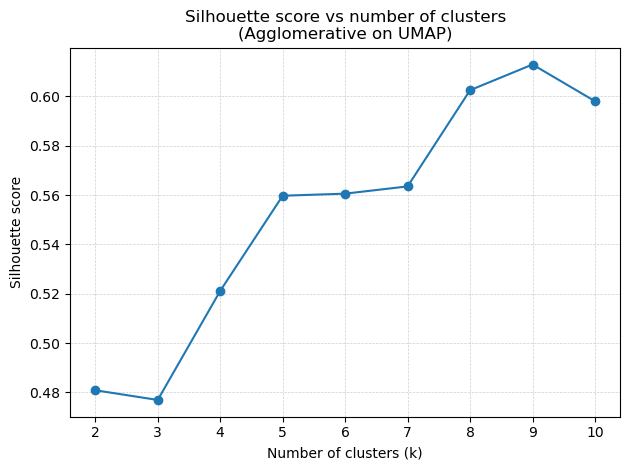

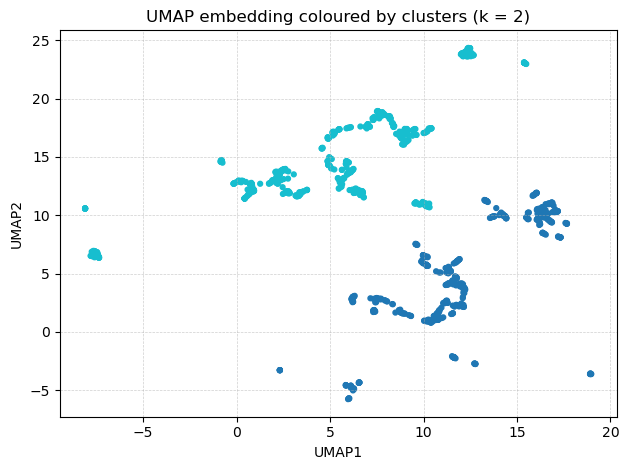

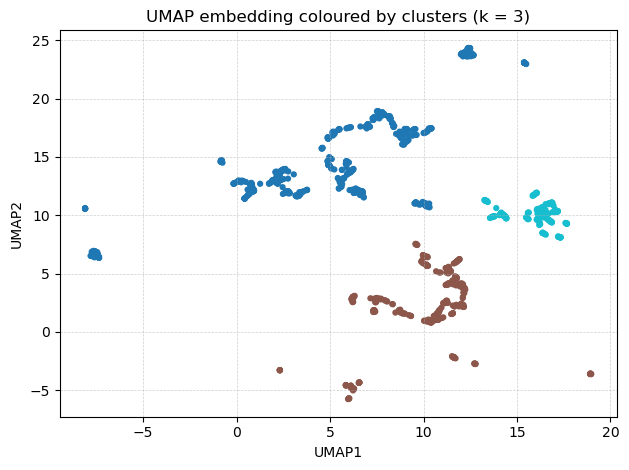

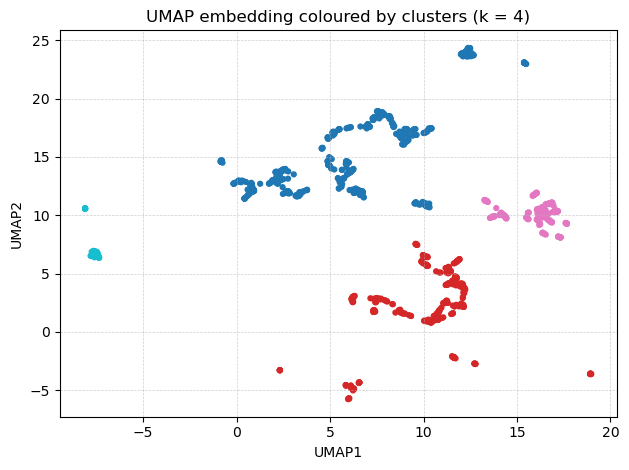

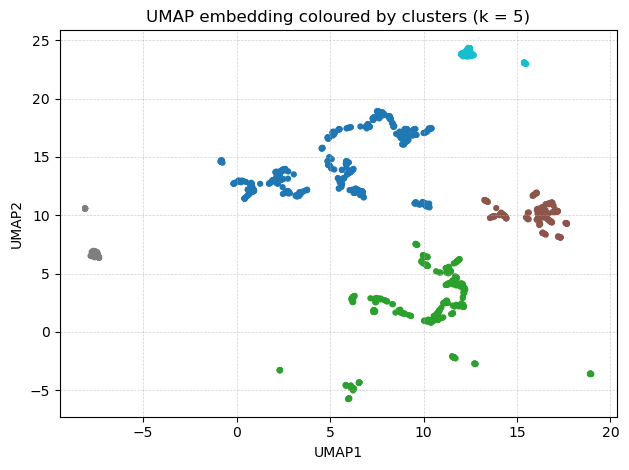

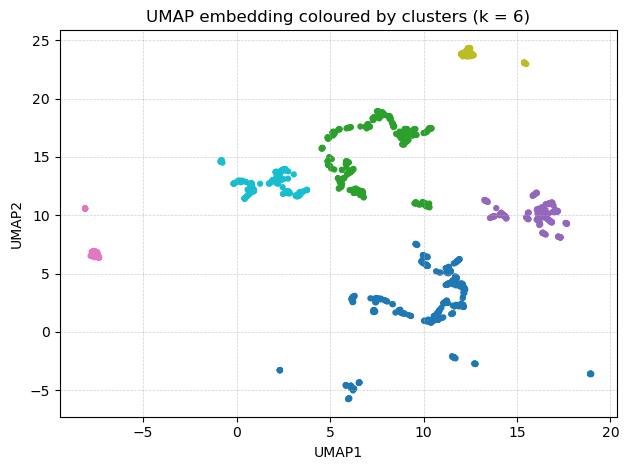

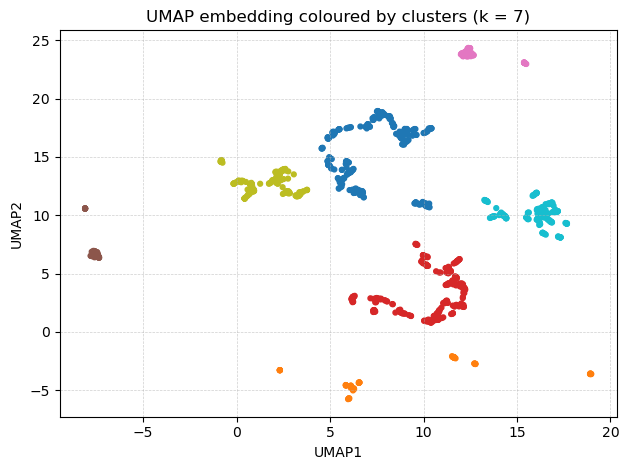

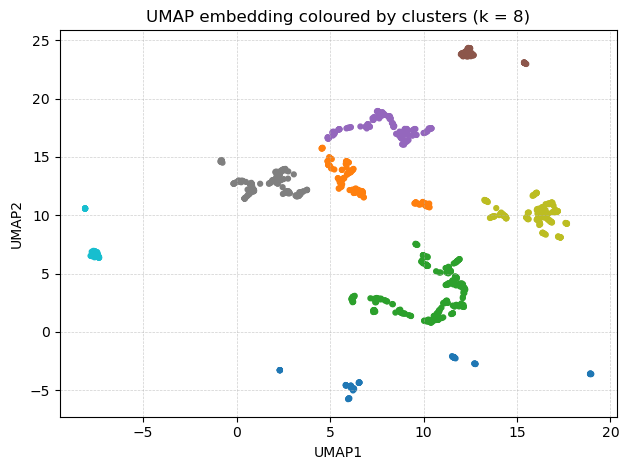

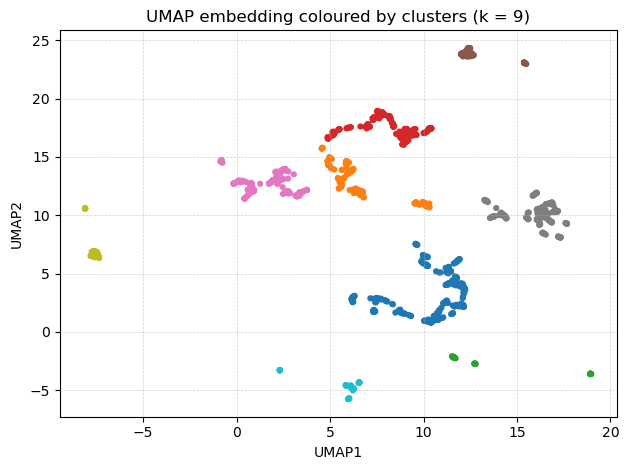

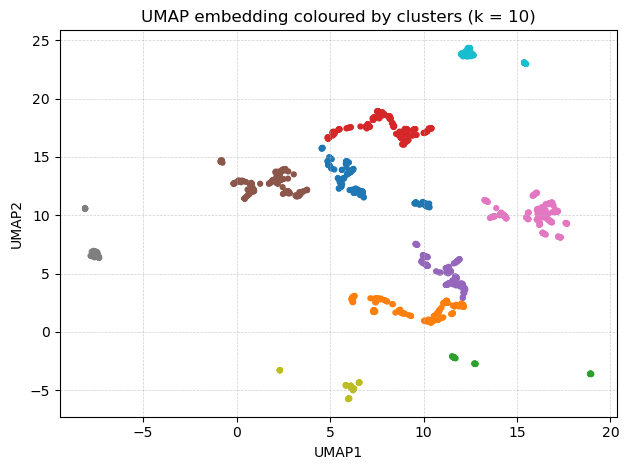

All done! Files saved in → /anvil/projects/x-cis250634/team5/Rufai/Flood-height-prediction/notebooks/Input_Clustering_Results


In [ ]:

# ## Parameters
INPUT_CSV    = "data/combined_features.csv"   # path to your data
OUTPUT_DIR   = "figures/Input_Clustering_Results"                 # folder to save figures / CSVs
SEED         = 42                        # random state for reproducibility
K_MIN, K_MAX = 2, 10                     # range of cluster counts
N_NEIGHBORS  = 15                        # UMAP n_neighbors
MIN_DIST     = 0.1                       # UMAP min_dist

def find_id_like_columns(df: pd.DataFrame) -> list[str]:
    id_like = []
    for c in df.columns:
        cl = c.lower()
        if (
            cl in {"id", "ids", "index", "record_id", "uid", "gid"}
            or cl.startswith(("id_", "idx"))
            or cl.endswith("_id")
            or cl == "unnamed: 0"
            or cl == "height_above"
        ):
            id_like.append(c)
    return id_like

# ##  Load data & preprocess
os.makedirs(OUTPUT_DIR, exist_ok=True)

df_raw = pd.read_csv(INPUT_CSV)
id_cols = find_id_like_columns(df_raw)

print("Not wanted columns dropped:", id_cols or "None")

# Drop IDs, coerce non-numeric to numeric, drop all-NaN cols
X_df = df_raw.drop(columns=id_cols, errors="ignore").copy()
for col in X_df.columns:
    if not np.issubdtype(X_df[col].dtype, np.number):
        X_df[col] = pd.to_numeric(X_df[col], errors="coerce")

nan_cols = [c for c in X_df.columns if X_df[c].isna().all()]
if nan_cols:
    X_df.drop(columns=nan_cols, inplace=True)
    print("All-NaN columns dropped:", nan_cols)

# scale
X = SimpleImputer(strategy="median").fit_transform(X_df.values)
X = StandardScaler().fit_transform(X)

print(f"Final feature matrix shape: {X.shape}")

# ## UMAP embedding (2-D)

# %%
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=N_NEIGHBORS,
    min_dist=MIN_DIST,
    metric="euclidean",
    random_state=SEED,
)
embedding = reducer.fit_transform(X)          # (n_samples, 2)

# DataFrame for easy plotting / saving
emb_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])

# Clustering + silhouette

# %%
k_range = range(K_MIN, K_MAX + 1)
labels_by_k = {}
silhouette_rows = []

for k in k_range:
    model = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels = model.fit_predict(embedding)
    labels_by_k[k] = labels
    sil = silhouette_score(embedding, labels, metric="euclidean")
    silhouette_rows.append({"k": k, "silhouette": sil})

sil_df = pd.DataFrame(silhouette_rows)
sil_df.to_csv(f"{OUTPUT_DIR}/silhouette_scores.csv", index=False)

# %% [markdown]
# ##  Plot silhouette curve

# %%
plt.figure()
plt.plot(sil_df["k"], sil_df["silhouette"], marker="o")
plt.title("Silhouette score vs number of clusters\n(Agglomerative on UMAP)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.grid(True, ls="--", lw=0.5, alpha=0.6)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/silhouette_scores.png", dpi=150)
plt.show()

# ## UMAP scatter for each *k*

# %%
for k in k_range:
    plt.figure()
    plt.scatter(
        emb_df["UMAP1"], emb_df["UMAP2"],
        c=labels_by_k[k], s=12, cmap="tab10"
    )
    plt.title(f"UMAP embedding coloured by clusters (k = {k})")
    plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
    plt.grid(True, ls="--", lw=0.5, alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/umap_k{k}.png", dpi=150)
    plt.show()

# ##  Save embedding + all labels (optional)

# %%
out_df = emb_df.copy()
# keep original IDs only for reference
for c in id_cols:
    out_df[c] = df_raw[c].values
# attach label columns
for k in k_range:
    out_df[f"labels_k{k}"] = labels_by_k[k]

out_df.to_csv(f"{OUTPUT_DIR}/umap_embedding_and_labels.csv", index=False)
print("All done! Files saved in →", os.path.abspath(OUTPUT_DIR))
